In [127]:
# Imports
import sys
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame, GeoSeries
from shapely import geometry
from shapely.ops import unary_union
import osmnx as ox
import os
import matplotlib.pyplot as plt
# quetzal-specific stuff
from syspy.spatial.graph.graphbuilder import GraphBuilder, OsmnxCleaner
from syspy.spatial.graph import graphbuilder
from quetzal.io.gtfs_reader import importer
from quetzal.model import stepmodel

In [128]:
training_folder = './../../'
input_path = training_folder + 'input/zones/'
input_folder = training_folder + 'inputs/'
model_path = './../../model/'

In [129]:
# Load the model with ber_zones
sm = stepmodel.read_json(model_path + 'zones')
if not type(sm.zones) == GeoDataFrame:
    sm.zones = GeoDataFrame(sm.zones, crs=sm.epsg)
sm.zones.plot()

## Road network

Build the road network graph from OpenStreetMap data and save it into GeoDataFrames

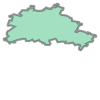

In [ ]:
# To-Do think whether it might make sense to increase the buffer to cover Brandenburg
hull = unary_union([x.buffer(1e-3) for x in sm.zones['geometry']])
hull

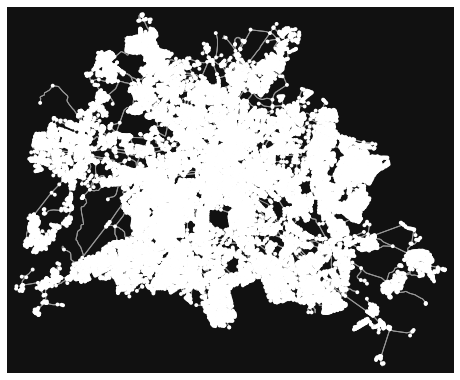

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [ ]:
# Download roads from OpenStreetMap (online) and save it in a graph
# using the OSMNX library
drive = ox.graph_from_polygon(hull, network_type='drive')
# Plot it
ox.plot_graph(drive)

In [ ]:
# Use OSMNX function to create GeoDataFrames from graph
road_nodes, road_links = ox.graph_to_gdfs(drive)

In [ ]:
# Let's have a look at the results
road_nodes.head(2)

y          x  street_count  ref highway  \
osmid                                                     
172539  52.565205  13.335501             3  NaN     NaN   
172545  52.567033  13.346605             4  NaN     NaN   

                         geometry  
osmid                              
172539  POINT (13.33550 52.56521)  
172545  POINT (13.34661 52.56703)

In [ ]:
#road_links.plot(figsize=(16,9))
road_links.head(2)

osmid lanes             name    highway maxspeed  \
u      v        key                                                       
172539 34694265 0    4610047     2  Holländerstraße   tertiary       50   
       34694336 0    5117633     2   Gotthardstraße  secondary       50   

                     oneway   length  \
u      v        key                    
172539 34694265 0     False  237.653   
       34694336 0     False  687.484   

                                                              geometry  ref  \
u      v        key                                                           
172539 34694265 0    LINESTRING (13.33550 52.56521, 13.33560 52.565...  NaN   
       34694336 0    LINESTRING (13.33550 52.56521, 13.33565 52.565...  NaN   

                    bridge width tunnel junction access service area est_width  
u      v        key                                                             
172539 34694265 0      NaN   NaN    NaN      NaN    NaN     NaN  NaN       NaN  
       34694336 0      NaN   NaN    NaN      NaN    NaN     NaN  NaN       NaN

In [ ]:
# Check if the columns you want to use later are in the columns above.
# If they appear as index names (printed bold), use the reset_index()
# function to create a new Data

In [ ]:
road_nodes = road_nodes.reset_index()
road_links = road_links.reset_index()

In [ ]:
# Rename columns and make them type string for later operations
road_links.rename(columns={'u': 'from', 'v': 'to'}, inplace=True)
road_nodes['osmid'] = road_nodes['osmid'].astype(str)
road_nodes = road_nodes.set_index('osmid')[['geometry']]
road_links[['from', 'to']] = road_links[['from', 'to']].astype(str)

In [ ]:
# We can drastically reduce the disc space needed for this table by
# reducing the complexity of LineString geometries.
# For our purpose it is enough to have the start and end point of a link.
# Let's write a function
def simplify_link(g):
    l = list(g.coords)
    return geometry.LineString([l[0], l[-1]])
# Apply the function to all our links
road_links['geometry'] = road_links['geometry'].apply(simplify_link)

In [ ]:
# Create a cleaner object and run cleaning functions on it
oc = OsmnxCleaner(
    road_links, 
    road_nodes, 
    a='from', 
    b='to'
)

In [ ]:
oc.add_reversed_links(
    direction_column='oneway', 
    reverse_value=False # the boolean has been stored as a string    
)
#oc.clean_geometries() # Doesn't work, but let's hope we don't need it
oc.fix_nodeset_consistency()

In [ ]:
#road_links.plot(figsize=(16,9))

Our road network is now saved in `oc.nodes` and `oc.links`

## Public Transport

For PT, we need to convert GTFS feeds into links and nodes GeoDataFrames

In [ ]:
# Load the GTFS feed
full_feed = importer.GtfsImporter(path='../../input/vbb_gtfs.zip', dist_units='m')
# downloaded from http://vbb.de/vbbgtfs
#print(full_feed.stops)

In [ ]:
# Restrict the feed to a given date in order to analyse a
# typical work day and not the whole week
start = min(full_feed.calendar['start_date'])
end = max(full_feed.calendar['end_date'])
feed_r = full_feed.restrict(
    dates=[start,start] # the dates must be within the feed start and end dates
)

In [ ]:
feed_r.calendar_dates

service_id      date exception_type
0           460  20220909              1
1          1313  20220909              1
2           104  20220909              1
3           189  20220909              1
4           854  20220909              1
...         ...       ...            ...
1291        388  20220909              1
1292        251  20220909              1
1293       1079  20220909              1
1294       1101  20220909              1
1295        532  20220909              1

[1296 rows x 3 columns]

In [ ]:
# We can also restrict it to hours
# TODO: nothing between 8 and 9 am?
time_range = ['16:00:00', '17:00:00']
feed_t = feed_r.restrict(time_range=time_range)
print(feed_t.stops)

                       stop_id stop_code                 stop_name stop_desc  \
2      de:12070:900215110:1:50       NaN     Bad Wilsnack, Bahnhof       NaN   
3      de:12070:900215110:2:51       NaN     Bad Wilsnack, Bahnhof       NaN   
4      de:12062:900415465:1:50       NaN           Prösen, Bahnhof       NaN   
6      de:12072:900245025:2:51       NaN        Rangsdorf, Bahnhof       NaN   
8             de:14713:8010205       NaN     Leipzig, Hauptbahnhof       NaN   
...                        ...       ...                       ...       ...   
28155        de:14626:8226:0:2       NaN  Bad Muskau, Maßmannplatz       NaN   
28157        de:14626:8231:0:2       NaN     Bad Muskau, Lindenhof       NaN   
28159        de:14626:8232:0:2       NaN      Bad Muskau, Siedlung       NaN   
28164    de:11000:900135001::9       NaN           S Buch (Berlin)       NaN   
28165    de:12069:900220019::9       NaN   Stahnsdorf, Waldschänke       NaN   

        stop_lat   stop_lon  location_t

In [ ]:
# And we can restrict it spacially if we write a suitable function
def spatial_restrict(feed, polygon, how='inner'):
    f = feed.copy()
    stops = f.stops.copy()
    stops['geometry'] = stops.apply(
        lambda r: geometry.Point([r['stop_lon'], r['stop_lat']]),
        axis=1
    )
    stops['included'] = stops['geometry'].apply(lambda g: polygon.contains(g))
    f.stops = f.stops.loc[stops['included'] == True]

    # relations
    f.stop_times = f.stop_times.loc[f.stop_times['stop_id'].isin(f.stops['stop_id'])]
    f.transfers = f.transfers.loc[f.transfers['from_stop_id'].isin(f.stops['stop_id'])]
    f.transfers = f.transfers.loc[f.transfers['to_stop_id'].isin(f.stops['stop_id'])]
    relevant_trips = (f.stop_times['trip_id'])
    f = f.restrict(trip_ids=relevant_trips)
    if how == 'inner':
        return f
    else:
        return feed.restrict(trip_ids=relevant_trips)

In [ ]:
# Give the hourly restricted feed to the spatial restriction
feed_s = spatial_restrict(feed_t, polygon=hull, how='inner')

In [ ]:
feed_s.calendar_dates[feed_s.calendar_dates['service_id']=='2']

service_id      date exception_type
8            2  20220909              1
656          2  20220909              1

In [ ]:
feed_s.calendar_dates[feed_s.calendar_dates['service_id']=='1384']

service_id      date exception_type
186       1384  20220909              1
834       1384  20220909              1

In [ ]:
dict = {}
for i in range(len(feed_s.calendar_dates['service_id'])):
    id = feed_s.calendar_dates['service_id'].iloc[i]
    if id in dict.keys():
        dict[id] += 1
    else:
        dict[id] = 1
print(any([dict[key]>1 for key in  dict.keys()]), dict)

True {'2': 2, '98': 2, '1618': 2, '1717': 2, '296': 2, '1033': 2, '718': 2, '1779': 2, '686': 2, '482': 2, '1663': 2, '589': 2, '1875': 2, '66': 2, '178': 2, '176': 2, '525': 2, '315': 2, '511': 2, '44': 2, '545': 2, '993': 2, '1900': 2, '180': 2, '182': 2, '179': 2, '1384': 2, '547': 2, '1359': 2, '1361': 2, '1827': 2, '514': 2, '1569': 2, '1878': 2, '1582': 2, '713': 2, '253': 2, '1724': 2, '49': 2, '932': 2, '1608': 2, '1172': 2, '406': 2, '1051': 2, '1397': 2, '255': 2, '1580': 2, '680': 2, '1766': 2, '1356': 2, '1365': 2, '50': 2, '38': 2, '760': 2, '127': 2, '554': 2, '371': 2, '94': 2, '1588': 2, '720': 2, '177': 2, '154': 2, '1669': 2, '1181': 2, '153': 2, '892': 2, '755': 2, '256': 2, '1756': 2, '470': 2, '1175': 2, '990': 2, '1419': 2, '1591': 2, '821': 2, '1881': 2, '25': 2, '1344': 2, '523': 2, '1621': 2, '1742': 2, '346': 2, '251': 2}


In [ ]:
# keep only first occurence of service_id by filtering calendar_dates
bool_indices = [x not in list(feed_s.calendar_dates['service_id'].iloc[0:n]) for n, x in enumerate(feed_s.calendar_dates['service_id'])]
feed_s.calendar_dates = feed_s.calendar_dates[bool_indices]


In [ ]:
dict = {}
for i in range(len(feed_s.calendar_dates['service_id'])):
    id = feed_s.calendar_dates['service_id'].iloc[i]
    if id in dict.keys():
        dict[id] += 1
    else:
        dict[id] = 1
print(any([dict[key]>1 for key in  dict.keys()]), dict)

False {'2': 1, '98': 1, '1618': 1, '1717': 1, '296': 1, '1033': 1, '718': 1, '1779': 1, '686': 1, '482': 1, '1663': 1, '589': 1, '1875': 1, '66': 1, '178': 1, '176': 1, '525': 1, '315': 1, '511': 1, '44': 1, '545': 1, '993': 1, '1900': 1, '180': 1, '182': 1, '179': 1, '1384': 1, '547': 1, '1359': 1, '1361': 1, '1827': 1, '514': 1, '1569': 1, '1878': 1, '1582': 1, '713': 1, '253': 1, '1724': 1, '49': 1, '932': 1, '1608': 1, '1172': 1, '406': 1, '1051': 1, '1397': 1, '255': 1, '1580': 1, '680': 1, '1766': 1, '1356': 1, '1365': 1, '50': 1, '38': 1, '760': 1, '127': 1, '554': 1, '371': 1, '94': 1, '1588': 1, '720': 1, '177': 1, '154': 1, '1669': 1, '1181': 1, '153': 1, '892': 1, '755': 1, '256': 1, '1756': 1, '470': 1, '1175': 1, '990': 1, '1419': 1, '1591': 1, '821': 1, '1881': 1, '25': 1, '1344': 1, '523': 1, '1621': 1, '1742': 1, '346': 1, '251': 1}


In [ ]:
# GTFS feeds are very complex. Have a look at Wikipedia for its structure
# We neet to perform some operations in order to transform it into a graph
feed = feed_s.copy()
feed.group_services()
#feed.build_stop_clusters(distance_threshold=300) # clusterize stops
feed.build_patterns(on='stop_id') # use on='cluster_id' if you built clusters


In [ ]:
feed_frequencies = feed.convert_to_frequencies(time_range=time_range)

100%|██████████| 707/707 [00:13<00:00, 53.16it/s]


In [ ]:
# We can build links and nodes now from the frequency graph
feed_frequencies.build_links_and_nodes()
feed_frequencies.build_geometries(use_utm=False)

export geometries in epsg: 32633


In [ ]:
feed_frequencies.links.head(2)

index                        a      trip_id  link_sequence  departure_time  \
0      0  de:11000:900092201:1:51  10141_109_0              1         54498.0   
1      1  de:11000:900093201:1:51  10141_109_0              2         54654.0   

   pickup_type                        b  arrival_time  drop_off_type   time  \
0            0  de:11000:900093201:1:51       54630.0              0  132.0   
1            0  de:11000:900094101:1:51       54768.0              0  114.0   

   ...  wheelchair_accessible bikes_allowed agency_id route_short_name  \
0  ...                      1             1         1     S1-10141_109   
1  ...                      1             1         1     S1-10141_109   

  route_long_name route_type  route_color route_text_color route_desc  \
0             NaN        109          NaN              NaN        NaN   
1             NaN        109          NaN              NaN        NaN   

                                            geometry  
0  LINESTRING (13.29032 52.63226, 13.30762 52.61729)  
1  LINESTRING (13.30762 52.61729, 13.32109 52.60626)  

[2 rows x 29 columns]

In [ ]:
feed_frequencies.nodes.head(1)

stop_id stop_code                     stop_name stop_desc  \
27  de:11000:900160004:3:54       NaN  S+U Lichtenberg Bhf (Berlin)       NaN   

    location_type      parent_station  wheelchair_boarding platform_code  \
27              0  de:11000:900160004                    0            17   

                              zone_id  level_id                   geometry  
27  5656_S+U_Lichtenberg_Bhf_(Berlin)     100.0  POINT (13.49649 52.51000)

In [ ]:
# Make stop_id the unique index of nodes
# Use cluster_id if you built clusters before
feed_frequencies.nodes.set_index('stop_id', inplace=True)
len(feed_frequencies.nodes.loc[feed_frequencies.nodes.index.duplicated()])

0

In [ ]:
feed_frequencies.links['route_type'].unique()

array([ 109,  700,  900,  100, 1000,  400,    2], dtype=int64)

In [ ]:
# Rename the route types
mapping = {0:'tram', 1:'subway', 2:'rail', 3:'bus',
    4:'ferry', 5:'cable_car', 6:'gondola', 7:'funicular'}
#Additional route types used in VBB Data:
ex_mapping = {100:'rail', 109:'rail', 400:'subway', 700:'bus', 900:'tram', 1000:'ferry'}
mapping.update(ex_mapping)

feed_frequencies.links['route_type'] = feed_frequencies.links['route_type'].apply(
    lambda t: mapping.get(t, t)
)

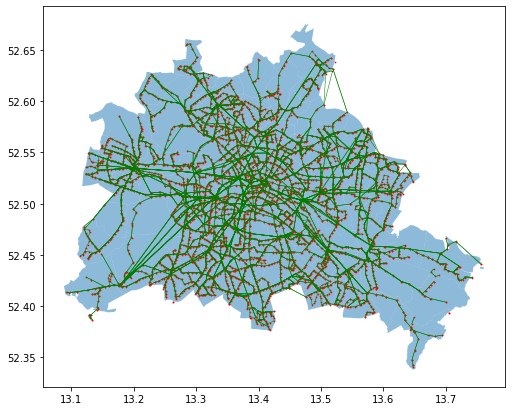

In [ ]:
# Plot the results using matplotlib notation
ax = sm.zones.plot(alpha=0.5, figsize=[17, 7])
ax = feed_frequencies.links.plot(linewidth=0.5, color='green', ax=ax)
plot= feed_frequencies.nodes.plot(markersize=0.5, color='red', ax=ax)

## Create the transport model

We have the network DataFrames and need to put them into a model now, to be able to run quetzal functions on it, that go beyond the scope of only one DataFrame

In [ ]:
# Add road network
sm.road_links = oc.links[['a', 'b', 'length', 'geometry', 'highway', 'maxspeed']]
sm.road_nodes = oc.nodes[['geometry']]

In [ ]:
# Assign PT network to it with the columns we need
sm.links = feed_frequencies.links[['trip_id', 'a', 'b', 'link_sequence', 'time', 'headway',
                                   'pattern_id', 'route_id', 'service_id', 'direction_id',
                                   'agency_id', 'route_type', 'route_color', 'geometry']]
sm.nodes = feed_frequencies.nodes[['geometry', 'stop_name', 'location_type']]

## Check integrity

Run quetzals integrity check functions to see if the networks are alright

In [ ]:
# check and fix name collision in the indicies
sm.integrity_fix_collision()

can not add prefixes on table:  footpaths


In [ ]:
sm.integrity_fix_road_network(cutoff=10, recursive_depth=5)

direct: 28124it [00:11, 2526.60it/s]
reversed: 28124it [00:11, 2551.42it/s]
28067it [00:12, 2331.28it/s]


In [ ]:
# Fix PT
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_collision()
sm.integrity_fix_circular_lines()
sm.integrity_fix_sequences()
sm.integrity_fix_nodeset_consistency()

dropped circular lines: ['17295_700_0', '17328_700_1', '17346_700_0', '19049_100_3', '17346_700_1', '17382_700_1', '17385_700_1', '17295_700_3', '19019_700_0', '19043_100_6', '17345_700_1', '17348_700_3', '17348_700_2', '17531_700_0', '19049_100_5', '17413_700_0', '17538_700_0', '19042_100_6', '17375_700_0', '17318_700_2', '17372_700_0', '17619_700_1', '17292_700_0', '17329_700_0', '17453_700_1', '17427_900_2', '17292_700_1', '17421_900_2']


In [ ]:
# Test
sm.integrity_test_all(errors='raise')

passed: integrity_test_circular_lines
passed: integrity_test_collision


28067it [00:02, 9665.98it/s] 


passed: integrity_test_dead_ends
passed: integrity_test_isolated_roads
passed: integrity_test_nodeset_consistency


28067it [00:12, 2325.33it/s]


passed: integrity_test_road_network
passed: integrity_test_road_nodeset_consistency
passed: integrity_test_sequences


## Cluster PT stops

Clustering has the advantage of reducing the model's file size and computational expenses. You can also leaf this step out.
To-Do: is n_clusters = 300 the best number?

In [ ]:
# Clusterize nodes
sm.preparation_clusterize_nodes(n_clusters=800)
sm.nodes.head(1)

geometry
cluster                             
0        POINT (13.575151 52.424495)

In [ ]:
len(sm.nodes)

800

<AxesSubplot:>

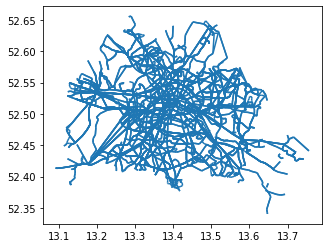

In [ ]:
sm.links.plot()

<AxesSubplot:>

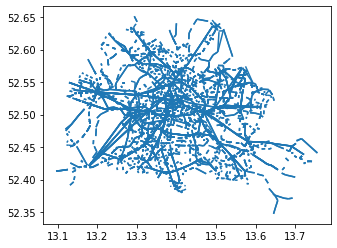

In [ ]:
# Now, some links might go from one stop to the same # To-Do: This does seem to remove to many links. Check back later if this is problematic.
sm.links = sm.links.loc[sm.links['a']!=sm.links['b']]
sm.links.plot()

In [ ]:
# Fix network integrity again
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_circular_lines()
sm.integrity_fix_sequences()
sm.integrity_fix_nodeset_consistency()
sm.integrity_fix_collision()

dropped circular lines: ['17344_700_1', '17535_700_0', '17377_700_2', '17315_700_1', '17368_700_4', '23568_700_0', '17349_700_2', '17325_700_1', '17415_700_0', '17334_700_0', '17325_700_0', '17402_700_0', '17535_700_1', '17399_700_0', '17372_700_1', '17349_700_1', '17406_700_0', '17368_700_1', '17377_700_3', '17376_700_0', '17334_700_1', '17378_700_0', '17534_700_4', '17329_700_2', '17298_700_0', '17402_700_1', '17383_700_0', '17383_700_1', '22754_700_1', '23567_700_3', '17318_700_0', '17309_700_0', '17320_700_1', '17320_700_0', '17315_700_2', '4242_700_1', '17315_700_0', '17334_700_2', '17344_700_0', '17336_700_0', '17367_700_0', '17370_700_1', '17347_700_3', '17305_700_3', '17413_700_1', '17318_700_1', '17347_700_1', '17357_700_0', '17366_700_0', '17348_700_0', '23567_700_1', '17412_700_0', '22754_700_0', '17349_700_0', '17366_700_2', '17334_700_3', '17342_700_1', '4242_700_0', '17534_700_6', '17309_700_1', '23567_700_2', '17370_700_0', '17315_700_3', '17360_700_1', '23568_700_1', '1

In [ ]:
# Check the integrity again
sm.integrity_test_all(errors='raise')

passed: integrity_test_circular_lines
passed: integrity_test_collision


28067it [00:03, 8845.71it/s] 


passed: integrity_test_dead_ends
passed: integrity_test_isolated_roads
passed: integrity_test_nodeset_consistency


28067it [00:11, 2382.12it/s]


passed: integrity_test_road_network
passed: integrity_test_road_nodeset_consistency
passed: integrity_test_sequences


In [ ]:
print(sorted([str(key)+": "+str(type(sm.__dict__[key]).__name__) for key in sm.__dict__.keys()]))

['broken_sequences: list', 'centroids: GeoDataFrame', 'checkpoint_links: GeoDataFrame', 'checkpoint_nodes: GeoDataFrame', 'circular_lines: list', 'coordinates_unit: str', 'dead_ends: list', 'debug: bool', 'disaggregated_nodes: GeoDataFrame', 'epsg: int', 'fare_attributes: DataFrame', 'fare_rules: DataFrame', 'footpaths: GeoDataFrame', 'jsons: DataFrame', 'lines: GeoDataFrame', 'links: GeoDataFrame', 'loaded_links: GeoDataFrame', 'loaded_nodes: GeoDataFrame', 'logit_scales: DataFrame', 'micro_zones: GeoDataFrame', 'missing_nodes: set', 'missing_road_nodes: set', 'mode_nests: DataFrame', 'networkcaster_neighbors: GeoDataFrame', 'networkcaster_road_access: GeoDataFrame', 'node_clusters: DataFrame', 'node_parenthood: GeoDataFrame', 'nodes: DataFrame', 'orphan_nodes: set', 'parameters: dict', 'road_links: GeoDataFrame', 'road_nodes: GeoDataFrame', 'road_to_transit: GeoDataFrame', 'segments: list', 'utility_values: DataFrame', 'walk_on_road: bool', 'zone_to_road: GeoDataFrame', 'zone_to_tran

In [ ]:
# Re-index nodes to prevent collision
sm.nodes.index = ['n_'+str(i) for i in sm.nodes.index]
sm.nodes = gpd.GeoDataFrame(sm.nodes, crs=sm.epsg)
sm.links['a'] = 'n_' + sm.links['a'].astype(str)
sm.links['b'] = 'n_' + sm.links['b'].astype(str)

In [ ]:
print(sorted([str(key)+": "+str(type(sm.__dict__[key]).__name__) for key in sm.__dict__.keys()]))

['broken_sequences: list', 'centroids: GeoDataFrame', 'checkpoint_links: GeoDataFrame', 'checkpoint_nodes: GeoDataFrame', 'circular_lines: list', 'coordinates_unit: str', 'dead_ends: list', 'debug: bool', 'disaggregated_nodes: GeoDataFrame', 'epsg: int', 'fare_attributes: DataFrame', 'fare_rules: DataFrame', 'footpaths: GeoDataFrame', 'jsons: DataFrame', 'lines: GeoDataFrame', 'links: GeoDataFrame', 'loaded_links: GeoDataFrame', 'loaded_nodes: GeoDataFrame', 'logit_scales: DataFrame', 'micro_zones: GeoDataFrame', 'missing_nodes: set', 'missing_road_nodes: set', 'mode_nests: DataFrame', 'networkcaster_neighbors: GeoDataFrame', 'networkcaster_road_access: GeoDataFrame', 'node_clusters: DataFrame', 'node_parenthood: GeoDataFrame', 'nodes: GeoDataFrame', 'orphan_nodes: set', 'parameters: dict', 'road_links: GeoDataFrame', 'road_nodes: GeoDataFrame', 'road_to_transit: GeoDataFrame', 'segments: list', 'utility_values: DataFrame', 'walk_on_road: bool', 'zone_to_road: GeoDataFrame', 'zone_to_t

In [ ]:
sm.links.sample()

trip_id      a      b  link_sequence  time  headway  \
index                                                                
link_4373  17333_700_1  n_736  n_477              5  60.0     1200   

            pattern_id   route_id service_id  direction_id agency_id  \
index                                                                  
link_4373  17333_700_1  17333_700        153             1       796   

          route_type route_color  \
index                              
link_4373        bus         NaN   

                                                    geometry  \
index                                                          
link_4373  LINESTRING (13.39291 52.45791, 13.38798 52.45672)   

                      disaggregated_a             disaggregated_b  
index                                                              
link_4373  node_de:11000:900069251::2  node_de:11000:900069252::2

## Network connectors

We have road and PT links and nodes. Now we need to connect them for people to be able to switch and enter as they want

In [ ]:
# Create a footpaths table
sm.preparation_footpaths(max_length=1000, n_clusters=300)
sm.footpaths.head(3)

a      b                                           geometry  \
footpath_0  n_353  n_733  LINESTRING (13.682813 52.37059549999999, 13.67...   
footpath_1  n_393  n_399  LINESTRING (13.37943418379348 52.4379184707660...   
footpath_2  n_393  n_565  LINESTRING (13.37943418379348 52.4379184707660...   

                length  voronoi        time  
footpath_0  742.752864        1  891.303437  
footpath_1  681.997496        1  818.396996  
footpath_2  768.458065        1  922.149678

In [ ]:
len(sm.footpaths)

1122

In [ ]:
# Create access and egress links (ntlegs)
threshold = 200
sm.preparation_ntlegs(
    short_leg_speed=3, # km/h
    long_leg_speed=7, # km/h
    threshold=threshold, # m
    zone_to_transit=True, # zone centroid - PT connectors
    zone_to_road=True, # zone centroid - road connectors
    n_ntlegs=5 # number of connectors
)

In [ ]:
# This is how the new tables look like
# Re-index them too
sm.zone_to_transit.index = ['ztt_'+str(i) for i in sm.zone_to_transit.index]
sm.zone_to_transit.sample(1)

a      b  rank   distance  \
ztt_211  zone_17  n_186     2  866.58972   

                                                  geometry direction  \
ztt_211  LINESTRING (13.4875735233478 52.57756311413183...    access   

         speed_factor  short_leg_speed  long_leg_speed     speed        time  \
ztt_211      2.081574                3               7  6.244721  499.577661   

          walk_time  
ztt_211  499.577661

In [ ]:
sm.zone_to_road.index = ['ztr_'+str(i) for i in sm.zone_to_road.index]
sm.zone_to_road.sample(1)

a         b  rank    distance  \
ztr_192  zone_95  27324712     1  362.861532   

                                                  geometry direction  \
ztr_192  LINESTRING (13.14098632721319 52.4610040969459...    access   

         speed_factor  short_leg_speed  long_leg_speed     speed        time  \
ztr_192      1.346962                3               7  4.040887  323.270972   

          walk_time  
ztr_192  323.270972

In [ ]:
sm.road_to_transit.index = ['rtt_'+str(i) for i in sm.road_to_transit.index]
sm.road_to_transit.sample(1)

a      b  rank    distance  \
rtt_4735  29858462  n_597     1  191.240084   

                                                   geometry direction  \
rtt_4735  LINESTRING (13.54849358718329 52.5525608512706...   eggress   

          speed_factor  short_leg_speed  long_leg_speed  speed        time  \
rtt_4735      0.977855                3               7    3.0  229.488101   

           walk_time  
rtt_4735  229.488101

# Networkcaster

## Rail

In [ ]:
rail = sm.copy()
rail.links = rail.links.loc[rail.links['route_type'].isin(['tram', 'subway', 'rail'])]
rail.preparation_cast_network(dumb_cast=True)

nearest_link: 100%|██████████| 7690/7690 [00:00<00:00, 69951.00it/s]


## Road

In [ ]:
road = sm.copy()


In [ ]:
road.links['route_type'].unique()

array(['rail', 'bus', 'tram', 'ferry', 'subway'], dtype=object)

In [ ]:
road.links = road.links.loc[road.links['route_type'].isin(['bus'])]

In [ ]:
len(sm.road_nodes), len(sm.road_links)

(28067, 135325)

In [ ]:
road.preparation_cast_network(
    nearest_method='nodes',
    n_neighbors_centroid=5, 
    n_neighbors=5, 
    penalty_factor=2,
    replace_nodes=False
)

17330_700_2: 100%|██████████| 360/360 [01:33<00:00,  3.87it/s]


## both road and rail

In [ ]:
sm.nodes

geometry
n_347  POINT (13.43858 52.54348)
n_729  POINT (13.35807 52.42185)
n_104  POINT (13.40207 52.58354)
n_189  POINT (13.26828 52.53214)
n_479  POINT (13.36358 52.60326)
...                          ...
n_668  POINT (13.50569 52.63666)
n_381  POINT (13.42663 52.45442)
n_251  POINT (13.54466 52.45721)
n_291  POINT (13.52878 52.41709)
n_532  POINT (13.61521 52.42981)

[769 rows x 1 columns]

In [ ]:
both = road.copy()
both.links = pd.concat([road.links, rail.links])

In [ ]:
both.analysis_lines(line_columns='all')

# monitoring

In [ ]:
from shapely.geometry import LineString

links = road.links
links['link_straight_length'] = links['geometry'].apply(
    lambda g: LineString([list(g.coords[0]), list(g.coords[-1])]).length
)

road.build_lines(sum_columns=['link_straight_length'])
lines = road.lines
lines['length'] = lines['geometry'].apply(lambda g: g.length)
lines['straight_length'] = lines['geometry'].apply(
    lambda g: LineString([list(g.coords[0]), list(g.coords[-1])]).length
)

lines['length_ratio'] = lines['length']/lines['link_straight_length']

Deprecated: replaced by analysis_lines


In [ ]:
lines.head(2)

trip_id  headway   pattern_id   route_id service_id  direction_id  \
0  10231_700_0      600  10231_700_0  10231_700        153             1   
1  10231_700_1      600  10231_700_1  10231_700        153             1   

  agency_id route_type  link_straight_length  \
0         1        bus              0.025712   
1         1        bus              0.028477   

                                            geometry    length  \
0  LINESTRING (13.39190 52.38865, 13.39342 52.388...  0.049094   
1  LINESTRING (13.36381 52.47506, 13.36303 52.474...  0.058677   

   straight_length  length_ratio  
0         0.025712      1.909350  
1         0.028466      2.060507

In [ ]:
# summary
title = str(
    (lines[['link_straight_length', 'straight_length', 'length']].sum() / 1000).astype(int).to_dict()
)[1:-1]

Text(0.5, 1.0, "'link_straight_length': 0, 'straight_length': 0, 'length': 0")

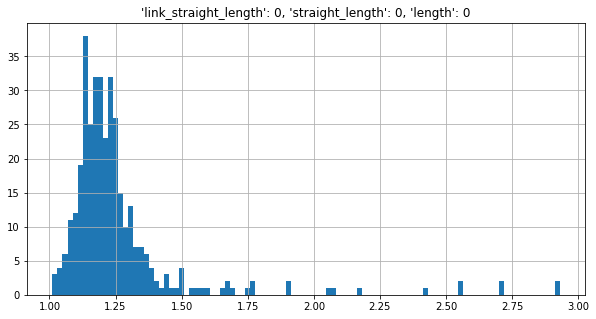

In [ ]:
ax = lines['length_ratio'].hist(bins=100, figsize=[10, 5])
ax.set_title(title)

In [ ]:
url = 'http://a.basemaps.cartocdn.com/light_nolabels/tile5/tile21/tile21.png'
url = 'http://a.basemaps.cartocdn.com/light_nolabels/tile21/tile21/tile5.png'

import matplotlib.pyplot as plt
def plot_networkcaster(raw, processed, figsize=[25, 25],url=None, *args, **kwargs):
    fig, ax = plt.subplots(2, 2,  figsize=figsize, tight_layout=True) 
    
    # print(0)
    buffer = raw.copy()
    # buffer_width = max(raw.zones['geometry'].apply(lambda g: max(abs(g.bounds[0]-g.bounds[2]), abs(g.bounds[1]-g.bounds[3]))))/2
    # buffer.zones['geometry'] = buffer.zones['geometry'].apply(lambda g: g.buffer(buffer_width))
    
    # print(1)
    # raw.road_nodes.plot(markersize=0.3, color='black', ax=ax.flat[0])
    raw.road_links.plot(linewidth=0.3, color='green', ax=ax.flat[0])
    ax.flat[0].set_title("Road network")
    
    # print(2)
    raw.links.plot(ax=ax.flat[1], color='blue', linewidth=0.5)
    gpd.GeoSeries(raw.nodes.geometry, crs=4326).plot(ax=ax.flat[1], color='black', markersize=10)
    gpd.GeoSeries(raw.disaggregated_nodes.geometry, crs=4326).plot(ax=ax.flat[1], color='pink', markersize=2)
    # if interested one could add disaggregated_nodes and connect them to center node.
    ax.flat[1].set_title("GTFS")

    # print(3)
    raw.road_links.plot(color='green', linewidth=0.5, ax=ax.flat[2])
    raw.links.plot(ax=ax.flat[2], color='blue', linewidth=0.2)
    ax.flat[2].set_title("raw GTFS & road network")

    # print(4)
    # gpd.GeoSeries(processed.road_links['geometry'], crs=4326).plot(ax=ax.flat[3], color='green', linewidth=0.5)
    # gpd.GeoSeries(processed.links['geometry'], crs=4326).plot(ax=ax.flat[3], color='blue', linewidth=0.5)
    processed.road_links.plot(ax=ax.flat[3], color='green', linewidth=0.5)
    processed.links.plot(ax=ax.flat[3], color='blue', linewidth=0.5)
    ax.flat[3].set_title("Processed GTFS & Road Network")
    
    # print(5)
    for _ax in ax.flat:
        _ax.set_xlim(buffer.zones['geometry'].total_bounds[0], buffer.zones['geometry'].total_bounds[2])
        _ax.set_ylim(buffer.zones['geometry'].total_bounds[1], buffer.zones['geometry'].total_bounds[3])

    return fig

In [ ]:
# check for broken GeoDataFrames
broken_gdf_keys = [key for key in both.__dict__.keys() if type(both.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in both.__dict__[key].columns]
print("Fixing:", broken_gdf_keys)
# fix broken GeoDataFrames
for key in broken_gdf_keys:
    both.__dict__[key] = gpd.GeoDataFrame(both.__dict__[key], crs=both.epsg)
broken_gdf_keys = [key for key in both.__dict__.keys() if type(both.__dict__[key]) == pd.core.frame.DataFrame and 'geometry' in both.__dict__[key].columns]
if len(broken_gdf_keys)>0:
    print("Broken GeoDataFrames:",broken_gdf_keys)
else:
    print("Successfully fixed.")

Fixing: ['footpaths', 'networkcaster_neighbors', 'networkcaster_road_access', 'road_to_transit', 'zone_to_transit', 'zone_to_road', 'node_clusters']
Successfully fixed.


could not add basemap: cannot identify image file <_io.BytesIO object at 0x0000015FB8197630>


<AxesSubplot:>

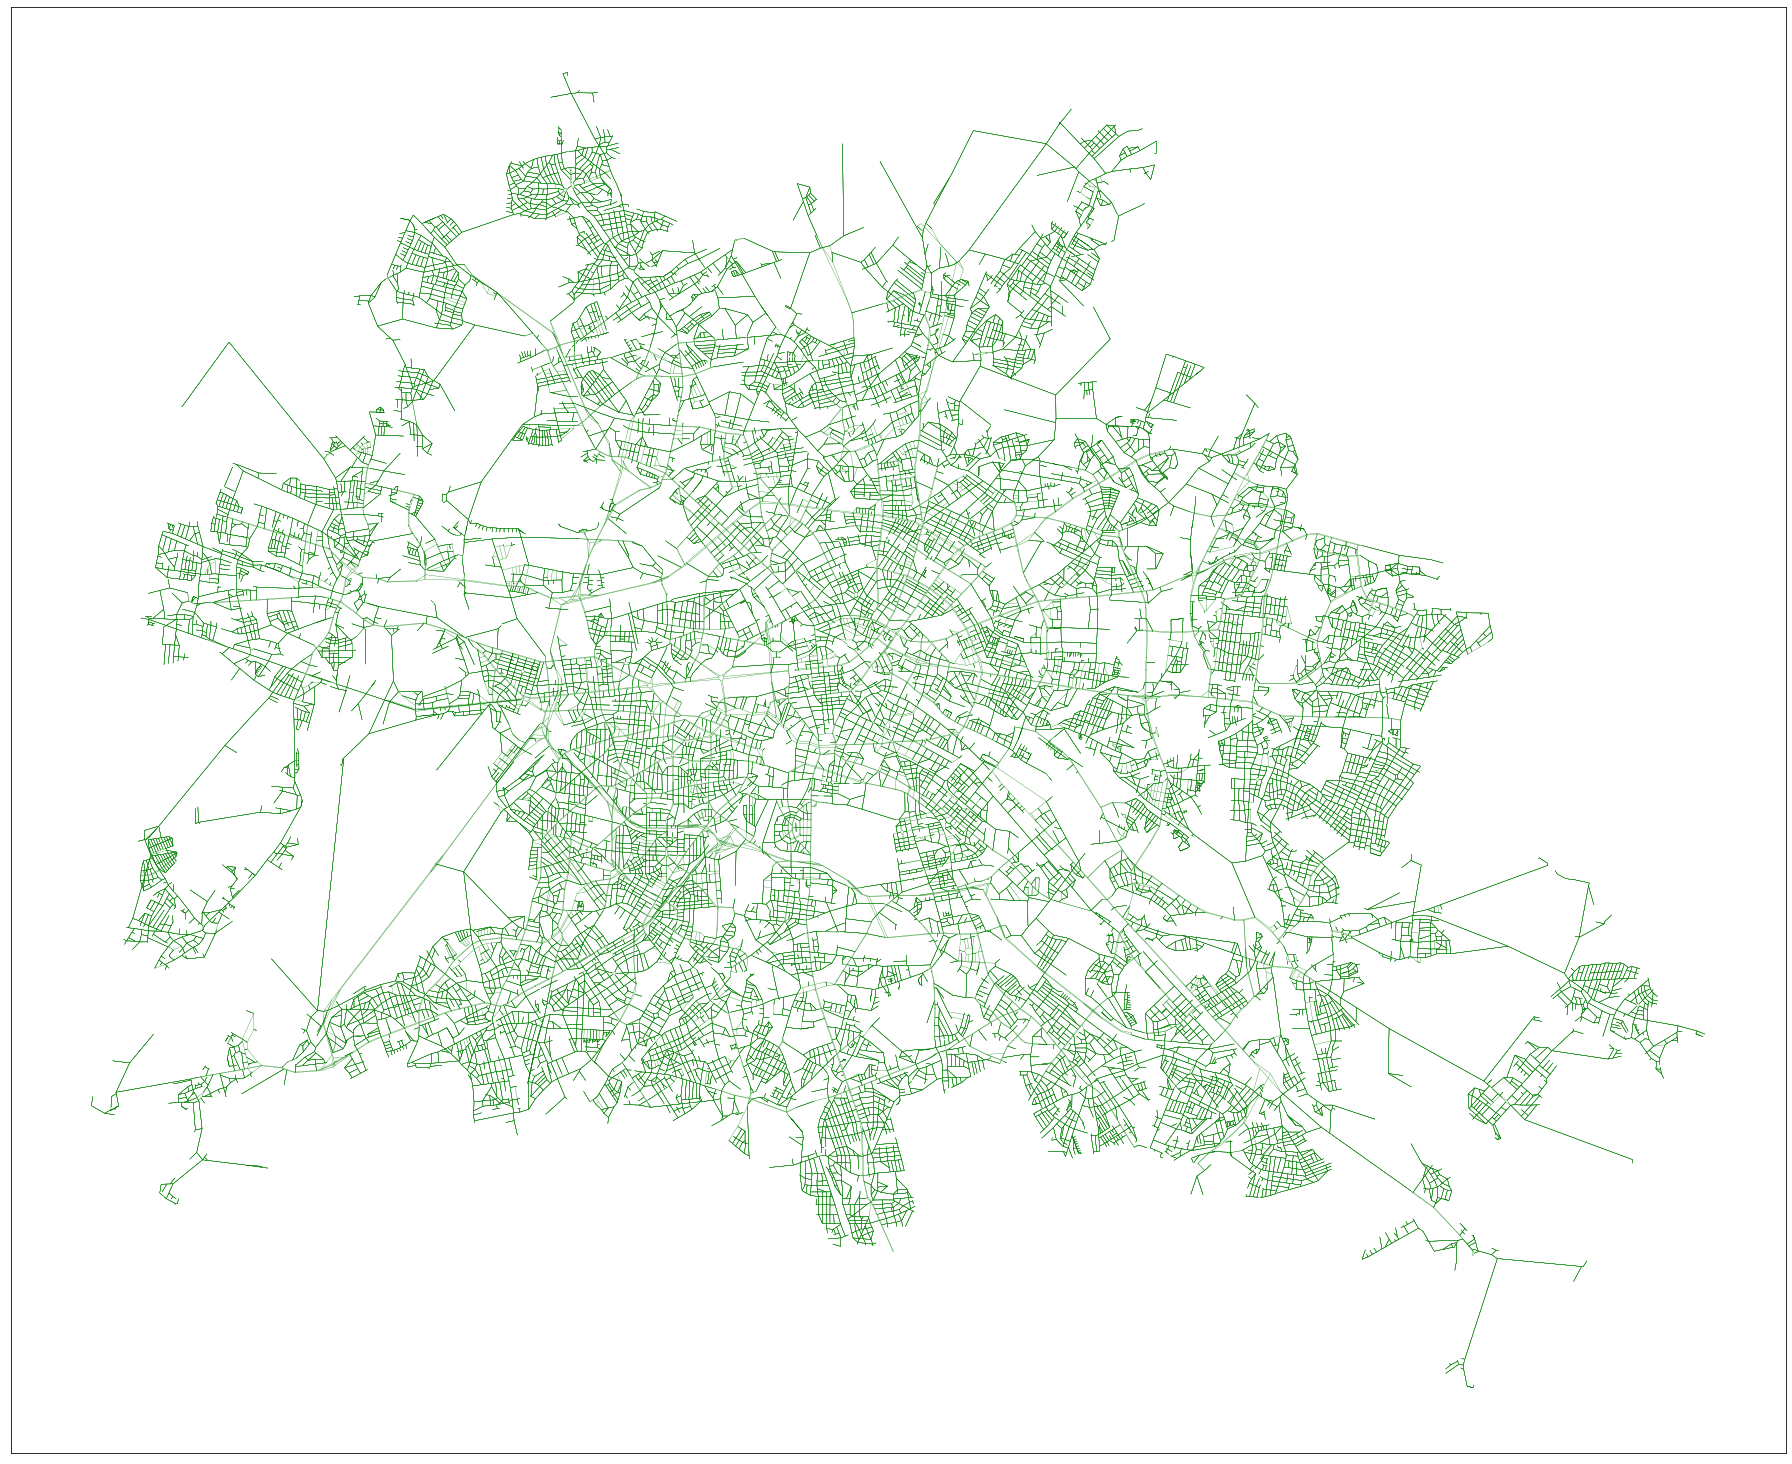

In [ ]:
fig, ax = plt.subplots(1, 1,  figsize=[25, 25], tight_layout=True) 
url='http://a.basemaps.cartocdn.com/light_nolabels/tile4/tile16/tile11.png'
url = 'http://a.basemaps.cartocdn.com/light_nolabels/tile5/tile21/tile21.png'
url = 'http://a.basemaps.cartocdn.com/light_nolabels/tile17/tile21/tile5.png'
url = 'http://a.basemaps.cartocdn.com/light_nolabels/tile1/tile1/tile1.png'

buffer = sm.copy()
buffer.zones['geometry'] = buffer.zones['geometry'].apply(lambda g: g.buffer(0.04))
sm.plot('road_links', linewidth=0.3, color='green',
                   ax=ax, basemap_url=url
                  , figsize=[20,20])

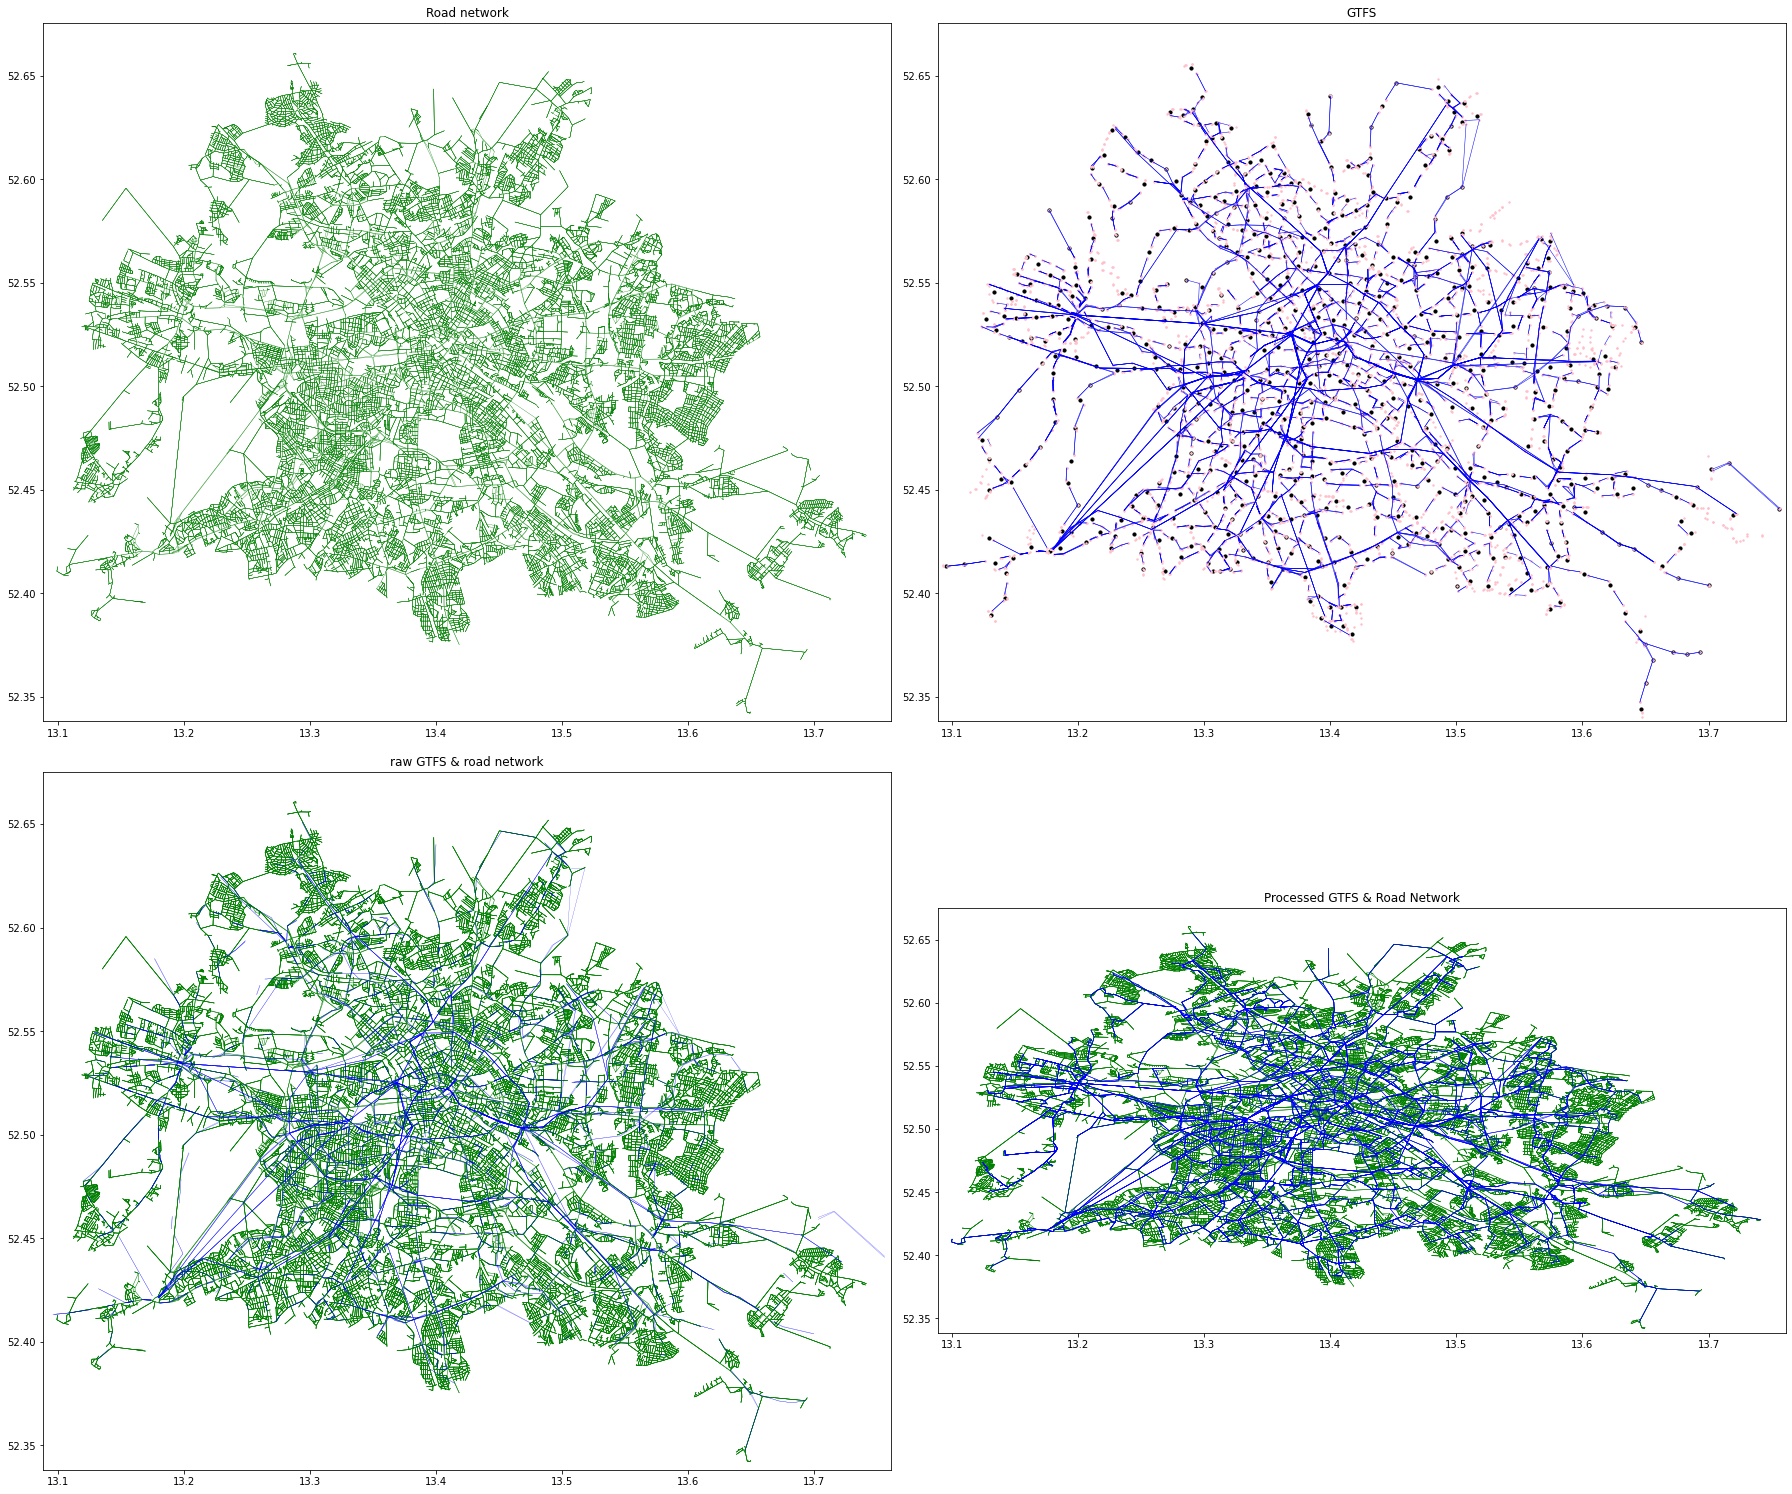

In [ ]:
fig = plot_networkcaster(raw=sm, processed=both, url=url)

## Save the model

We have a complete network with connectors. Now save it.

quetzal provides two functions. One is the to_zip (and read_zip for loading again), which is very fast, but the file format is hdf5, which is not compatible with other programs.

The other option is to_json (and read_json), which saves tables as GeoJSON format. This is great to look at them in GIS software like QGIS, but it is slower for larger models.

Both functions take the location string as a first argument and optionally the only_attributes argument, where you can pass a list of table names that should be saved. All others are discarded.

In [ ]:
#sm.to_json('../../model/network')
both.to_json('../../model/network')

to_hdf(overwriting): 100%|██████████| 40/40 [01:01<00:00,  1.54s/it]

could not save geometry from table fare_rules
could not save geometry from table fare_attributes
could not save geometry from table mode_nests
could not save geometry from table logit_scales
could not save geometry from table utility_values
could not save geometry from table jsons
could not save attribute: missing_road_nodes
could not save attribute: missing_nodes
could not save attribute: orphan_nodes
could not save attribute: networkcaster
